In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import h5py
import array
from collections import Counter
import daw_readout
from matplotlib.colors import LogNorm
from tqdm import trange
from tqdm import tqdm
import time  
import os 

np.set_printoptions(suppress=True) # to make tiny values appear as zero
np.set_printoptions(precision=4)   # number of digits in floats (or longfloats)
#np.set_printoptions(formatter={'float_kind':"{:.2f}"})
#np.set_printoptions()

%matplotlib inline

# Set formats
DARK=False
if(DARK==False):
    form='.k'
    plt.style.use(['default']) 
    fontcolor='k'
else:
    form='.w'
    plt.style.use(['dark_background'])
    fontcolor='w'


SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

params = {
    'font.family': 'serif',
    'font.size' : 14, 'axes.titlesize' : 14, 'axes.labelsize' : 14, 'axes.linewidth' : 1,
    # ticks
    'xtick.labelsize' : 14, 'ytick.labelsize' : 14, 'xtick.major.size' : 8, 'xtick.minor.size' : 4,
    'ytick.major.size' : 8, 'ytick.minor.size' : 4, 'xtick.major.width' : 1, 'xtick.minor.width' : 1,
    'ytick.major.width' : 1, 'ytick.minor.width' : 1, 'xtick.direction' : 'in', 'ytick.direction' : 'in',
    # markers
    'lines.markersize' : 4, 'lines.markeredgewidth' : 1, 'errorbar.capsize' : 5, 'lines.linewidth' : 1.5,
    #'lines.linestyle' : None, 'lines.marker' : None,
    'savefig.bbox' : 'tight', 'legend.fontsize' : 14,
    'axes.labelsize': 14, 'axes.titlesize':16, 'xtick.labelsize':14, 'ytick.labelsize':14,
    'backend': 'Agg', 'mathtext.fontset': 'dejavuserif',
    'figure.facecolor':'w',
    #pad
    'axes.labelpad':8,
    # ticks
    'xtick.major.pad': 7,   'xtick.minor.pad': 7,   
    'ytick.major.pad': 4, 'ytick.minor.pad': 4,
}
plt.rcParams.update(params)

In [2]:
path = "/mnt/data/PMT/R8520_406/"   ##### file path
V = 1.7
T = input()
name = "LV2415_anodereadout_LV2414_dualreadout_20240821_LED_"+str(V)+"V_"+str(T)+"ns_400_ratio_run0" 
filesnum = 1 ### number of files

hdf5_filename = path + name + ".h5"
feather_filename = path + name + ".feather"
filename = {}
filepath = {}
dataload = {}
for i in range(filesnum):
    filename[i] = name + "_raw_b0_seg" + str(i) +".bin"
    filepath[i] = path + filename[i]
    dataload[i] = daw_readout.DAWDemoWaveParser(filepath[i])




#name_3 = 'run_gamma_$(date_raw_b0_seg0.bin'

### Background data
#data0 = daw_readout.DAWDemoWaveParser([path+name[0]])#### background data


In [3]:
data = []

calbl = 10 ### Length used to calculate baseline
calstart = 95### Index started to calculate area
callen= 35  ### Length used to calculate area

for num in range(filesnum):
# Process the waveforms and store the data in lists
    i = 0
    for wave in tqdm(dataload[num]):
        baseline2 = np.sum(wave.Waveform[:calbl]) / calbl
        area = (baseline2 * callen - np.sum(wave.Waveform[calstart : calstart+callen]))
        height = (baseline2 - np.min(wave.Waveform[calstart : calstart+callen]))
        data.append({
            'Files': num,   ####file name/number
            'EventID': i,   ####index in file
            'Channel': wave.Channel, #### PMT Channel
            'Timestamp': wave.Timestamp, 
            'Baseline': wave.Baseline,
            'Baseline2': baseline2,
            'Height': height,
            'Area': area,
            'AtH':area/height,
            'Waveform':wave.Waveform
            })
        i += 1


    
# Convert lists to pandas DataFrames
df = pd.DataFrame(data)




# Print the total number of events for each channel



print("CH0 Total Events:",len(df.EventID[df.Channel==0]))
print("CH1 Total Events:",len(df.EventID[df.Channel==1]))

0it [00:00, ?it/s]

114465it [00:01, 98845.72it/s]/tmp/ipykernel_121937/1037512450.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  'AtH':area/height,
360414it [00:03, 93503.95it/s] 


CH0 Total Events: 120138
CH1 Total Events: 120138


In [4]:
df

,Files,EventID,Channel,Timestamp,Baseline,Baseline2,Height,Area,AtH,Waveform
0,0,0,0,143544,15200,15200.8,3127.8,5779.0,1.847625,"[15203, 15200, 15203, 15202, 15200, 15201, 151..."
1,0,1,1,143544,15338,15337.8,4.8,-11.0,-2.291667,"[15340, 15335, 15336, 15337, 15336, 15340, 153..."
2,0,2,2,143544,8117,8116.4,7.4,-15.0,-2.027027,"[8115, 8118, 8119, 8116, 8115, 8115, 8120, 811..."
3,0,3,1,393544,15338,15336.9,3.9,-34.5,-8.846154,"[15334, 15338, 15337, 15337, 15335, 15337, 153..."
4,0,4,2,393544,8116,8117.2,7.2,-13.0,-1.805556,"[8117, 8116, 8116, 8117, 8117, 8119, 8120, 811..."
...,...,...,...,...,...,...,...,...,...,...
360409,0,360409,1,30033991064,15339,15339.1,119.1,245.5,2.061293,"[15339, 15337, 15339, 15343, 15335, 15340, 153..."
360410,0,360410,2,30033991064,8118,8117.6,6.6,11.0,1.666667,"[8117, 8119, 8116, 8117, 8116, 8117, 8117, 811..."
360411,0,360411,0,30034241064,15201,15200.5,2846.5,6116.5,2.148779,"[15203, 15198, 15202, 15203, 15198, 15202, 151..."
360412,0,360412,1,30034241064,15336,15337.7,27.7,73.5,2.653430,"[15338, 15338, 15335, 15339, 15338, 15336, 153..."


In [ ]:
"""
n = int(input())

plt.figure(figsize=(15,4))
plt.title('Waveforms of two channels')
plt.xlabel('$t$')
plt.ylabel('adc')
plt.xlim(90,130)
plt.plot(df.Baseline[2*n]-df.Waveform[2*n],label='CH'+str(df.Channel[2*n])+', time = '+str(df.Timestamp[2*n]))
plt.plot((df.Baseline[2*n+1]-df.Waveform[2*n+1]),label='CH'+str(df.Channel[2*n+1])+', time = '+str(df.Timestamp[2*n+1]))
plt.legend()
plt.show()
"""

In [5]:
ch1_area_0 = []
ch0_area_0 = []

ch0_area = []
ch1_area = []

area_ratio = []

for i in tqdm(range(0,len(df.Area))):
    if df.Channel[i] == 1:
        ch1_area.append(df.Area[i])
    elif df.Channel[i] == 0:
        ch0_area.append(df.Area[i])

"""
for i in tqdm(range(0,len(df.Area))):
    if df.Channel[i] == 1:
        ch1_area_0.append(df.Area[i])
    elif df.Channel[i] == 0:
        ch0_area_0.append(df.Area[i])

for i in tqdm(range(0,len(ch0_area_0))):
    if ch1_area_0[i] > 60:
        ch0_area.append(ch0_area_0[i])
        ch1_area.append(ch1_area_0[i])
"""
for i in tqdm(range(0,len(ch0_area))):
    if ch1_area[i] != 0:
        area_ratio.append(ch0_area[i]/ch1_area[i])
    else:
        area_ratio.append(0)

100%|██████████| 120138/120138 [00:00<00:00, 3837886.39it/s]


/tmp/ipykernel_121937/3655431194.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


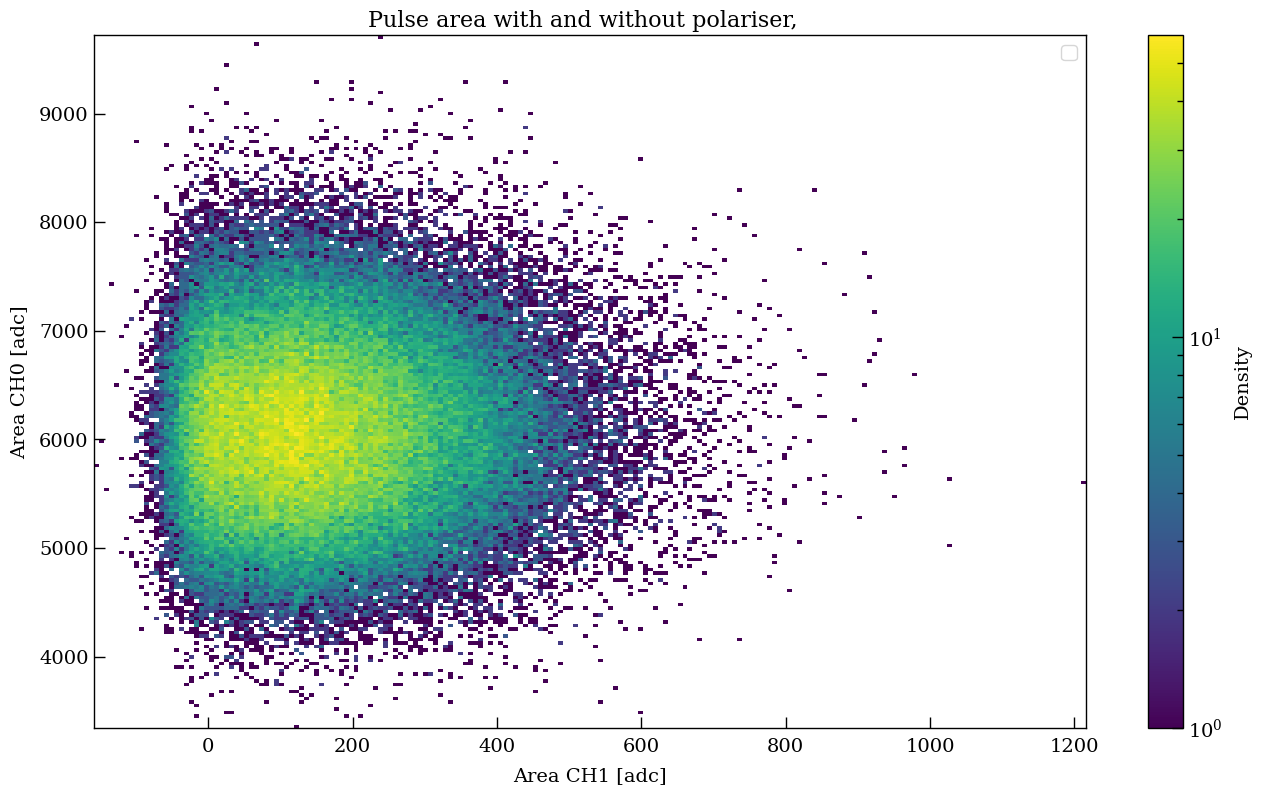

In [6]:
bin1 = np.linspace(np.min(ch1_area), np.max(ch1_area),200) ###x Height
bin2 = np.linspace(np.min(ch0_area), np.max(ch0_area), 200)###y Area
bins = [bin1,bin2]

H, xedges, yedges = np.histogram2d(ch1_area,ch0_area,bins)
H = np.rot90(H) 
H = np.flipud(H)
Hmasked = np.ma.masked_where(H==0,H)

plt.figure(figsize=(16, 9))
plt.title('Pulse area with and without polariser, '+str()+' '+str())
plt.xlabel('Area CH1 [adc]')
plt.ylabel('Area CH0 [adc]')

plt.pcolormesh(xedges,yedges,Hmasked,norm=LogNorm())
plt.colorbar(label='Density')
plt.legend()
plt.show()

100%|██████████| 120138/120138 [00:00<00:00, 4178305.56it/s]

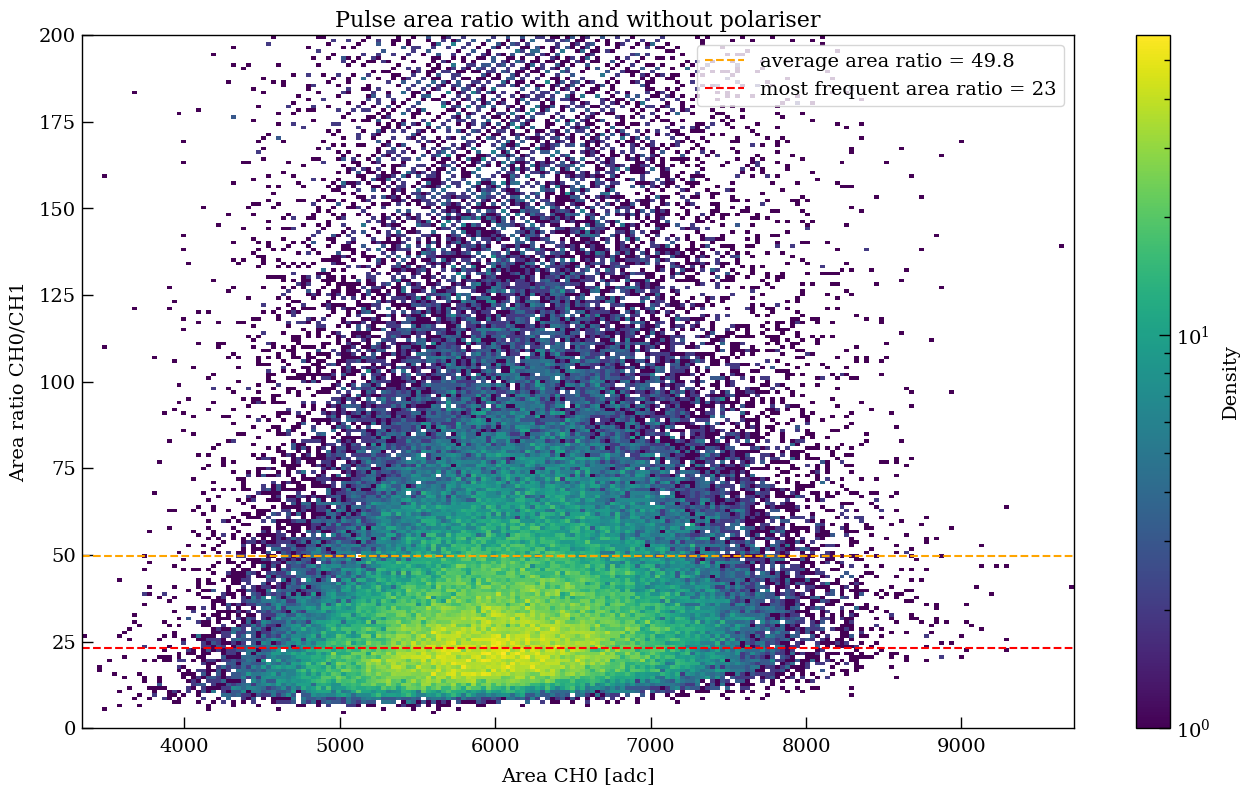

In [7]:
bin3 = np.linspace(0,200,200) ###x Height
bin4 = np.linspace(np.min(ch0_area), np.max(ch0_area), 200)###y Area
bin2s = [bin4,bin3]

filtered_area_ratio = []
filtered_ch0_area = []
for i in tqdm(range(0,len(area_ratio))):
    if area_ratio[i]!=0:
        filtered_area_ratio.append(area_ratio[i])
        filtered_ch0_area.append(ch0_area[i])

area_average = np.average(filtered_area_ratio)

H, xedges, yedges = np.histogram2d(filtered_ch0_area,filtered_area_ratio,bin2s)
H = np.rot90(H) 
H = np.flipud(H)
Hmasked = np.ma.masked_where(H==0,H)\

H_sum = []

for i in range(0,len(H)):
    H_sum.append(np.sum(H[i][:]))

area_frequent = np.where(H_sum == np.max(H_sum))[0][0]

plt.figure(figsize=(16, 9))
plt.title('Pulse area ratio with and without polariser')
plt.xlabel('Area CH0 [adc]')
plt.ylabel('Area ratio CH0/CH1')

plt.pcolormesh(xedges,yedges,Hmasked,norm=LogNorm())
plt.hlines(y=area_average,xmin=np.min(ch0_area),xmax=np.max(ch0_area),
           linestyle='--',color='orange',
           label='average area ratio = '+str(round(area_average,1)))
plt.hlines(y=area_frequent,xmin=np.min(ch0_area),xmax=np.max(ch0_area),
           linestyle='--',color='red',
           label='most frequent area ratio = '+str(area_frequent))
plt.colorbar(label='Density')
plt.legend()
plt.show()

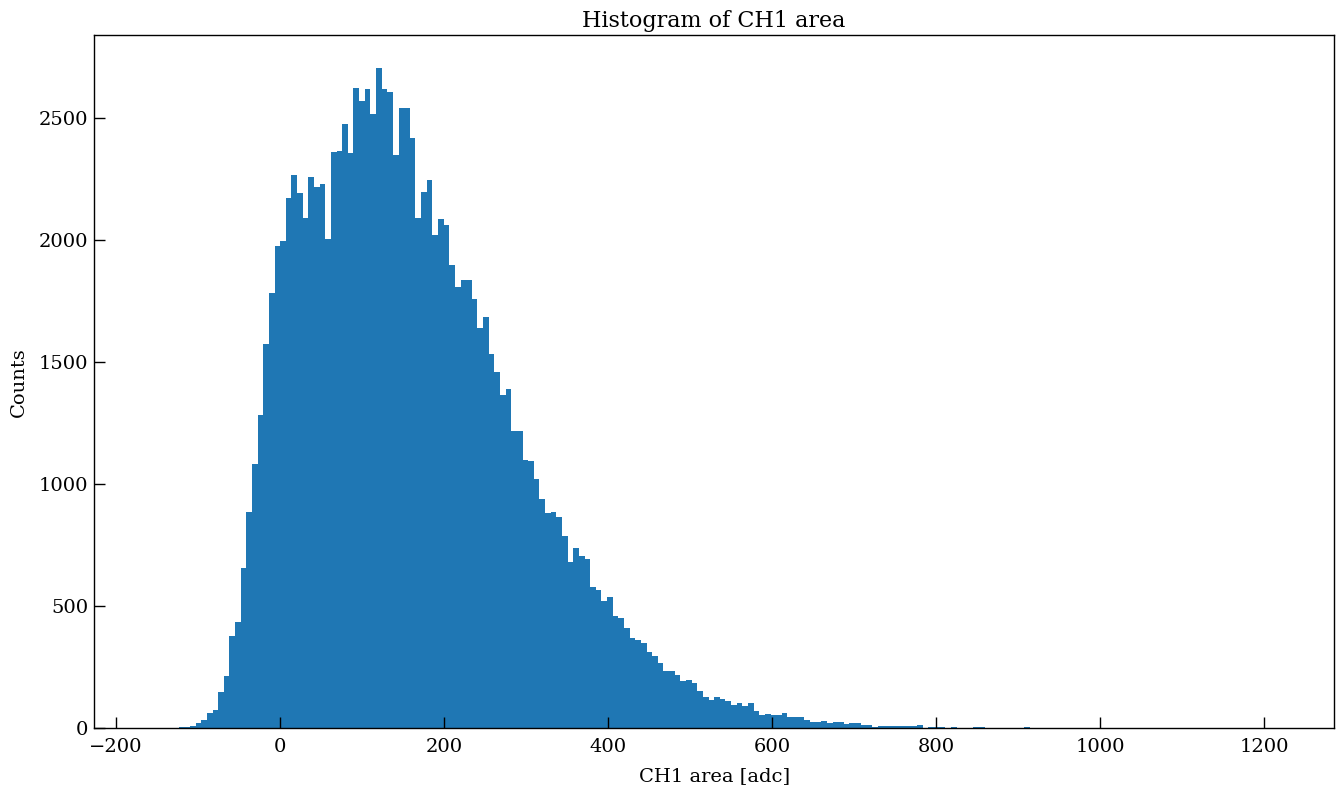

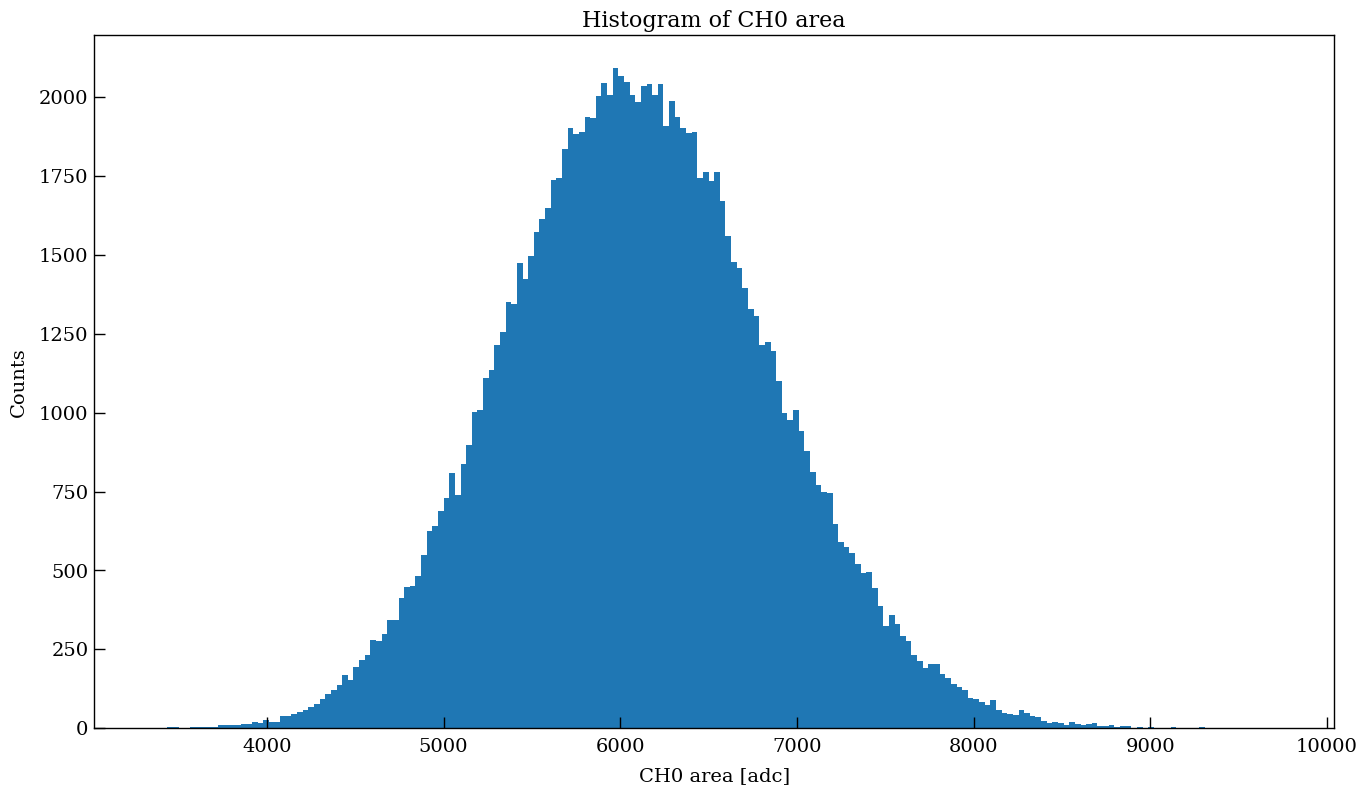

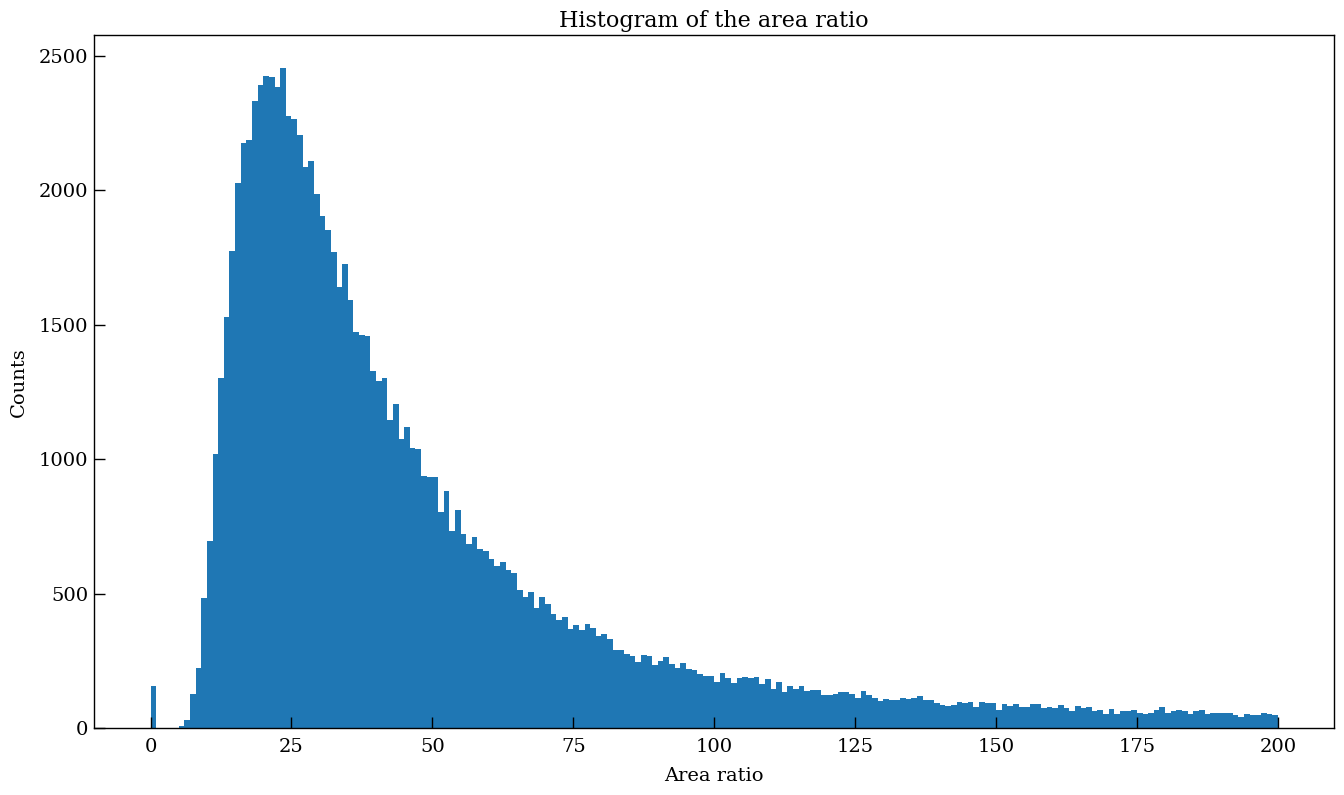

In [9]:
plt.figure(figsize=(16,9))
plt.title('Histogram of CH1 area')
plt.xlabel('CH1 area [adc]')
plt.ylabel('Counts')
plt.hist(ch1_area,bins=200)
plt.show()

plt.figure(figsize=(16,9))
plt.title('Histogram of CH0 area')
plt.xlabel('CH0 area [adc]')
plt.ylabel('Counts')
plt.hist(ch0_area,bins=200)
plt.show()

plt.figure(figsize=(16,9))
plt.title('Histogram of the area ratio')
plt.xlabel('Area ratio')
plt.ylabel('Counts')
plt.hist(area_ratio,bins=200,range=(0,200))
plt.show()

### h5 ###

In [ ]:
def test_hdf5_compressed(df, filename):
    start_time = time.time()
    #df.to_hdf(filename, key='data', mode='w', complib='zlib', complevel=9)
    #充分利用多核
    df.to_hdf(filename, key='data', mode='w', complib='blosc:blosclz', complevel=9)
    
    write_time = time.time() - start_time

    file_size = os.path.getsize(filename)
    print("h5 Write Time: ", write_time)
    print("h5 File Size: ", file_size)

    return write_time,  file_size

# 添加 Feather 格式支持
def test_feather(df, filename):
    start_time = time.time()
    df.to_feather(filename)
    write_time = time.time() - start_time

    file_size = os.path.getsize(filename)
    print("feather Write Time:", write_time)
    print("feather File Size:", file_size)

    return write_time,  file_size

In [ ]:
test_hdf5_compressed(df, hdf5_filename )
#test_feather(df, feather_filename)

In [ ]:
#### Read df from .h5 and .feather
'''
start_time = time.time()
df_h5 = pd.read_hdf(hdf5_filename, key='data')
read_time = time.time() - start_time
print("h5 Read Time: ", read_time)
time0 = time
start_time = time.time()
df_feather =  pd.read_feather(feather_filename)
read_time = time.time() - start_time
print("feather Read Time: ", read_time)
'''

In [ ]:
'''
for num in range(filesnum):
# Process the waveforms and store the data in lists
    i = 0
    for wave in tqdm(dataload[num]):
        baseline2 = np.sum(wave.Waveform[:calbl]) / calbl
        area = (baseline2 * callen - np.sum(wave.Waveform[calstart : calstart+callen]))
        height = baseline2 - np.min(wave.Waveform[calstart : calstart+callen])
        data.append({
            'Files': num,   ####file name/number
            'EventID': i,   ####index in file
            'Channel': wave.Channel, #### PMT Channel
            'Timestamp': wave.Timestamp, 
            'Baseline': wave.Baseline,
            'Baseline2': baseline2,
            'Height': height,
            'Area': area,
            'AtH':area/height,
            })
        i += 1
        '''